In [ ]:
# Introduction to the JupyterLab and Jupyter Notebooks

This is a short introduction to two of the flagship tools created by [the Jupyter Community](https://jupyter.org).

> **⚠️Experimental!⚠️**: This is an experimental interface provided by the [JupyterLite project](https://jupyterlite.readthedocs.io/en/latest/). It embeds an entire JupyterLab interface, with many popular packages for scientific computing, in your browser. There may be minor differences in behavior between JupyterLite and the JupyterLab you install locally. You may also encounter some bugs or unexpected behavior. To report any issues, or to get involved with the JupyterLite project, see [the JupyterLite repository](https://github.com/jupyterlite/jupyterlite/issues?q=is%3Aissue+is%3Aopen+sort%3Aupdated-desc).

## JupyterLab 🧪

**JupyterLab** is a next-generation web-based user interface for Project Jupyter. It enables you to work with documents and activities such as Jupyter notebooks, text editors, terminals, and custom components in a flexible, integrated, and extensible manner. It is the interface that you're looking at right now.

**For an overview of the JupyterLab interface**, see the **JupyterLab Welcome Tour** on this page, by going to `Help -> Welcome Tour` and following the prompts.

> **See Also**: For a more in-depth tour of JupyterLab with a full environment that runs in the cloud, see [the JupyterLab introduction on Binder](https://mybinder.org/v2/gh/jupyterlab/jupyterlab-demo/HEAD?urlpath=lab/tree/demo).

## Jupyter Notebooks 📓

**Jupyter Notebooks** are a community standard for communicating and performing interactive computing. They are a document that blends computations, outputs, explanatory text, mathematics, images, and rich media representations of objects.

JupyterLab is one interface used to create and interact with Jupyter Notebooks.

**For an overview of Jupyter Notebooks**, see the **JupyterLab Welcome Tour** on this page, by going to `Help -> Notebook Tour` and following the prompts.

> **See Also**: For a more in-depth tour of Jupyter Notebooks and the Classic Jupyter Notebook interface, see [the Jupyter Notebook IPython tutorial on Binder](https://mybinder.org/v2/gh/ipython/ipython-in-depth/HEAD?urlpath=tree/binder/Index.ipynb).

## An example: visualizing data in the notebook ✨

Below is an example of a code cell. We'll visualize some simple data using two popular packages in Python. We'll use [NumPy](https://numpy.org/) to create some random data, and [Matplotlib](https://matplotlib.org) to visualize it.

Note how the code and the results of running the code are bundled together.

<ipython-input-7-1c2a50815924>:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  extrema_indices = np.zeros(((num_extrema + 2)), dtype=numpy.int)
<ipython-input-7-1c2a50815924>:187: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ls = numpy.asarray(([1],Lk[0,1]))
<ipython-input-7-1c2a50815924>:189: VisibleDeprecationWarning: Crea

reached stop in  2  iterations.


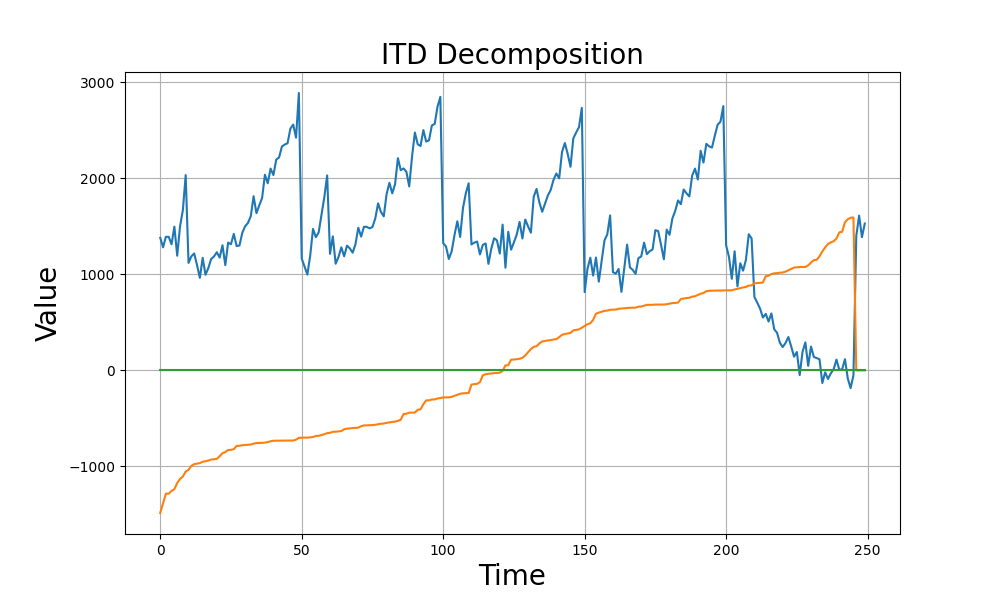

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import numpy

def detect_peaks(x: list[numpy.float64]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return np.empty(1, np.int64)
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size!= 0:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]# hacky solution because numba does not like hstack tuple arrays
    #np.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(np.where((vil <= 0) & (vix > 0))[0])
    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = np.unique(np.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    return ind



def ITD(data: list[int]):
    # notes:
    # The pythonic way to COPY an array is to do x[:] = y[:]
    # do x=y and it wont copy it, so any changes made to X will also be made to Y.
    # also, += does an append instead of a +
    # math.sqrt is 7x faster than numpy.sqrt but not designed for complex numbers.
    # specifying the type and size in advance of all variables accelerates their use, particularily when JIT is used.
    # However, JIT does not permit arbitrary types like UNION? maybe it does but i havnt figured out how.
    # this implementation uses a lot of for loops because they can be easily vectorized by simply replacing
    # range with numba.prange and also because they will translate well to other languages
    # this implementation of FABADA is not optimized for 2d arrays, however, it is easily swapped by changing the means
    # estimation and by simply changing all other code to iterate over 2d instead of 1d
    # care must be taken with numba parallelization/vectorization
    #we will now implement the intrinsic time-scale decomposition algorithm.
    #function H=itd(x)
    N_max = 10
    working_set = numpy.zeros_like(data)
    working_set[:] = data[:]
    xx = working_set.transpose()
    E_x = sum(numpy.square(working_set)) # same thing as E_x=sum(x.^2);
    counter = 0
    STOP = False
    #we have to initialize the array, because awkward doesn't have an empty array initializer-
    #and because we do not know the first value! of the array
    counter = counter + 1
    Lx, Hx = itd_baseline_extract(xx)
    L1 = numpy.asarray(Lx)
    H = numpy.asarray(Hx)
    STOP = stop_iter(xx, counter, N_max, E_x)
    if STOP:
        print("finished in one iteration")
        return H

    xx = numpy.asarray(L1)

    while 1:
        counter = counter + 1
        Lx, Hx = itd_baseline_extract(xx)
        L1= numpy.asarray(Lx)
        H = numpy.vstack((H,numpy.asarray(Hx)))

        STOP = stop_iter(xx, counter, N_max, E_x)
        if STOP:
            print("reached stop in ", counter, " iterations.")
            H = numpy.vstack((H, numpy.asarray(L1)))
            break
        xx = numpy.asarray(L1)
    return H

def stop_iter(xx,counter,N_max,E_x) -> (bool):
    if (counter>N_max):
        return True
    Exx= sum(numpy.square(xx))
    exr = 0.01 * E_x
    truth = numpy.less_equal(Exx,exr)
    if truth:
       print("value exceeded truth")
       return True
    #https://blog.ytotech.com/2015/11/01/findpeaks-in-python/ we may want to switch
    #to the PeakUtils interpolate function for better results
    #however, since there is no filtering going on here, we will use Marcos Duarte's code
    pks1= set(detect_peaks(xx))
    pks2= set(detect_peaks(-xx))

    pks= pks1.union(pks2)
    if (len(pks)<=7):
        return True

    return False

#"""% Matlab Written by Linshan Jia (jialinshan123@126.com)
#% Xi'an Jiaotong University
#% Version 1.0.0
#% 2018-11-04"""

def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = numpy.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])


def itd_baseline_extract(data: list[int]) -> (list[int], list[int]):

   #dt = np.dtype([('value', np.float64, 16), ('index', np.int, (2,))])
    x = numpy.asarray(numpy.transpose(data[:])) #x=x(:)';
    t = list(range(x.size))
    # t=1:length(x); should do the same as this

    alpha=0.5
    idx_max = detect_peaks(x)
    val_max = x[idx_max] #get peaks based on indexes
    idx_min= detect_peaks(-x)
    val_min = x[idx_min]
    val_min= -val_min

    H = numpy.zeros_like(x)
    L = numpy.zeros_like(x)
    #y_interp = np.interp(x_interp, x, y) yields an interpolation of the function y_interp = f(x_interp)
    # based on a previous interpolation y = f(x), where x.size = y.size, x_interp.size = y_interp.size.
    #scipy is (idx_min,val_min)(t)[idx_max]
    #interpolator = interp1d(extrema_indices, baseline_knots / x[extrema_indices], kind='linear')(t)

    #x = np.interp(y_max, y_data, x_data,  left=None, right=None, period=None)
    #max_line = numpy.interp(max(max_knots),max_knots, idx_max,  left=None, right=None, period=None)[t]


    num_extrema = len(val_max) + len(val_min)# numpy.union1d(idx_max,idx_min)
    extrema_indices = np.zeros(((num_extrema + 2)), dtype=numpy.int)
    extrema_indices[1:-1] = np.union1d(idx_max, idx_min)
    extrema_indices[-1] = len(x) - 1

    baseline_knots = np.zeros(len(extrema_indices))
    baseline_knots[0] = np.mean(x[:2])
    baseline_knots[-1] = np.mean(x[-2:])


    baseline_knots = np.zeros(len(extrema_indices))
    baseline_knots[0] = np.mean(x[:2])
    baseline_knots[-1] = np.mean(x[-2:])

    for k in range(1, len(extrema_indices) - 1):
        baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] + \
        (extrema_indices[k] - extrema_indices[k - 1]) / (extrema_indices[k + 1] - extrema_indices[k - 1]) * \
        (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) + \
                            alpha * x[extrema_indices[k]]

    interpolator = numpy.interp(t,extrema_indices, baseline_knots / x[extrema_indices])

    #print(interpolator_numba,interpolator,len(interpolator), len(interpolator_numba))
    Lk1 = np.asarray(alpha * interpolator[idx_min] + val_min * (1 - alpha))
    Lk2 = np.asarray(alpha * interpolator[idx_max] + val_max * (1 - alpha))

    Lk1 = numpy.hstack((np.atleast_2d(idx_min).T, np.atleast_2d(Lk1).T))
    Lk2 = numpy.hstack((np.atleast_2d(idx_max).T, np.atleast_2d(Lk2).T))
    Lk = numpy.vstack((Lk1,Lk2))
    Lk = Lk[Lk[:,1].argsort()]
    if Lk.size > 6:
        Lk = Lk[1:-1,:]

    Ls = numpy.asarray(([1],Lk[0,1]))
    Lk = numpy.vstack((Ls,Lk))
    Ls = numpy.asarray(([len(x)], Lk[-1, 1]))
    Lk = numpy.vstack((Lk, Ls))

    idx_Xk = numpy.concatenate(([0], extrema_indices, [x.size]))  # idx_Xk=[1,idx_cb,length(x)];
    for k in range(len(idx_Xk) - 5):
        for j in range(idx_Xk[k], idx_Xk[k + 1]):
            vk = (Lk[k + 1, 1] - Lk[k,1])
            sk = (x[idx_Xk[k + 1]] - x[idx_Xk[k]])
            kij = vk / sk  # $compute the slope K
            L[j] = Lk[k,1] + kij * (x[j] - x[idx_Xk[k]])
#
    H = numpy.subtract(x, L)

    return L,H


# Just a random pattern
time = np.arange(50)
values = np.where(time < 10, time**3, (time-9)**2)
# Repeat the pattern 5 times
seasonal = []
for i in range(5):
    for j in range(50):
        seasonal.append(values[j])
# Plot
time_seasonal = np.arange(250)


noise = np.random.randn(250)*100
seasonal += noise
seasonal_upward = seasonal + np.arange(250)*10



big_event = np.zeros(250)
big_event[-50:] = np.arange(50)*-50
non_stationary = seasonal_upward + big_event


non_stationary_float = non_stationary.astype(dtype=float)
results = ITD(non_stationary_float)




plt.figure(figsize=(10,6))
plt.plot(results.T)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.title("ITD Decomposition" , fontsize=20)
plt.grid(True)
plt.show()

## Next steps 🏃

This is just a short introduction to JupyterLab and Jupyter Notebooks. See below for some more ways to interact with tools in the Jupyter ecosystem, and its community.

### Other notebooks in this demo

Here are some other notebooks in this demo. Each of the items below corresponds to a file or folder in the **file browser to the left**.

- [**`Lorenz.ipynb`**](Lorenz.ipynb) uses Python to demonstrate interactive visualizations and computations around the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system). It shows off basic Python functionality, including more visualizations, data structures, and scientific computing libraries.
- [**`sqlite.ipynb`**](sqlite.ipynb) demonstrates how an in-browser sqlite kernel to run your own SQL commands from the notebook. It uses the [jupyterlite/xeus-sqlite-kernel](https://github.com/jupyterlite/xeus-sqlite-kernel).

### Other sources of information in Jupyter

- **More on using JupyterLab**: See [the JupyterLab documentation](https://jupyterlab.readthedocs.io/en/stable/) for more thorough information about how to install and use JupyterLab.
- **More interactive demos**: See [try.jupyter.org](https://try.jupyter.org) for more interactive demos with the Jupyter ecosystem.
- **Learn more about Jupyter**: See [the Jupyter community documentation](https://docs.jupyter.org) to learn more about the project, its community and tools, and how to get involved.
- **Join our discussions**: The [Jupyter Community Forum](https://discourse.jupyter.org) is a place where many in the Jupyter community ask questions, help one another, and discuss issues around interactive computing and our ecosystem.